In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [14]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
        print(max(data))
        print(min(data))
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=2)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [15]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [16]:
Params={'L': 15, 'P': 0.3780703389644099, 'Inh': 0.6358066855917539, 'Trest': -4.739855306871973, 'Trelative': -0.5845066272055987, 'C_h': 0.984180380236879, 'Tipo_red': 2}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

21.575342465753426
1.0
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


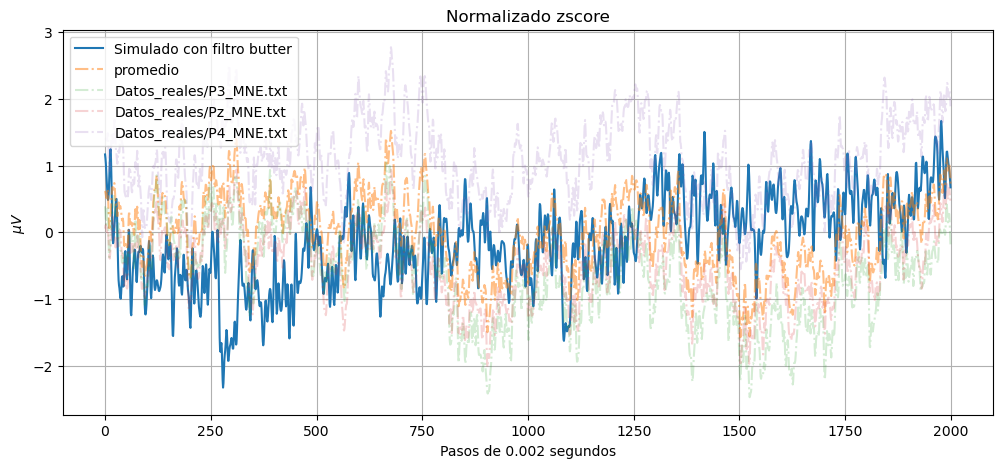

In [ ]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75]
481
481
241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [-14.532180661077335, 5.6680621657378225] ---- [-14.32164081   2.88721965]
Theta [-19.62142673112885, 0.8030452426947619] ---- [-18.96553014   1.24867868]
Alpha [-23.005983815214094, 1.255564473779694] ---- [-21.50450614   1.65515045]
Beta [-26.637060976014162, 1.4326748230847342] ---- [-28.90417157   2.145858  ]


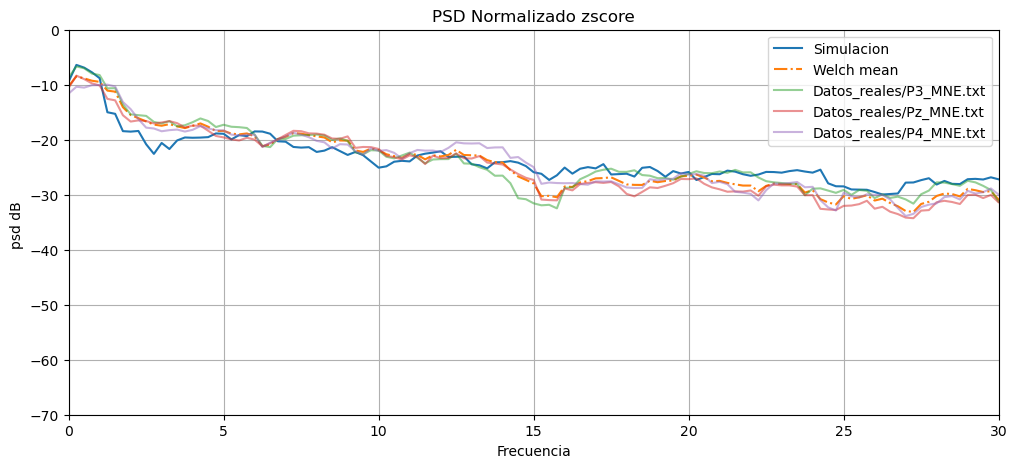

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
print(generated_data["frequencies"][:32])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [8]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}", 
                            storage=f"sqlite:///Estudios/Full_Trest_p/Small_world1/Chi30_{Normalizacion}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=100),
                            sampler=optuna.samplers.TPESampler(seed=42,n_startup_trials=500)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=2000)


[I 2024-11-06 12:47:43,139] Using an existing study with name 'Chi30_zscore' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:47:46,318] Trial 31 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[I 2024-11-06 12:48:12,126] Trial 32 finished with value: 378.5485587103661 and parameters: {'L': 62, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_4904/1061044799.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:13,039] Trial 33 finished with value: inf and parameters: {'L': 21, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:13,674] Trial 34 finished with value: 79087.86627337305 and parameters: {'L': 18, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:25,259] Trial 35 finished with value: 79087.86627337305 and parameters: {'L': 46, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:54,171] Trial 36 finished with value: 79087.86627337305 and parameters: {'L': 59, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:54,439] Trial 37 finished with value: inf and parameters: {'L': 12, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:55,133] Trial 38 finished with value: inf and parameters: {'L': 21, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:55,507] Trial 39 finished with value: inf and parameters: {'L': 15, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:48:57,912] Trial 40 finished with value: inf and parameters: {'L': 31, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:49:23,097] Trial 41 finished with value: 79087.86627337305 and parameters: {'L': 57, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:49:23,432] Trial 42 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:49:25,157] Trial 43 finished with value: 79087.86627337305 and parameters: {'L': 28, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:49:43,242] Trial 44 finished with value: 79087.86627337305 and parameters: {'L': 53, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:49:43,491] Trial 45 finished with value: inf and parameters: {'L': 11, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:49:44,699] Trial 46 finished with value: inf and parameters: {'L': 25, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:50:26,944] Trial 47 finished with value: inf and parameters: {'L': 66, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:50:34,192] Trial 48 finished with value: inf and parameters: {'L': 42, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:51:01,786] Trial 49 finished with value: 79087.86627337305 and parameters: {'L': 59, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 1}. Best is trial 24 with value: 173.05234522080374.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-06 12:51:03,908] Trial 50 finished with value: inf and parameters: {'L': 30, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 2}. Best is trial 24 with value: 173.05234522080374.
[W 2024-11-06 12:51:15,006] Trial 51 failed with parameters: {'L': 68, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^

KeyboardInterrupt: 

In [35]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


Chi30_max_global

Trial 1:
Params: {'L': 71, 'P': 0.6800588289926386, 'Inh': 0.48396237500446815, 'Trest': -2.0491012306005203, 'Trelative': 0.8960167935326897, 'C_h': 0.2332087536142065, 'Tipo_red': 3}
Value: 221.60036197909395

Trial 2:
Params: {'L': 31, 'P': 0.40342378337771306, 'Inh': 0.4740837714197771, 'Trest': -1.8565195211008796, 'Trelative': 1.9938787652249486, 'C_h': 0.6634064286119825, 'Tipo_red': 3}
Value: 221.78726763467392

Trial 3:
Params: {'L': 47, 'P': 0.11429202998124499, 'Inh': 0.4728380312979866, 'Trest': -2.9919152990881326, 'Trelative': 0.24543549274796472, 'C_h': 0.7719295837601932, 'Tipo_red': 4}
Value: 403.95421402979485

Trial 4:
Params: {'L': 61, 'P': 0.5579530811715765, 'Inh': 0.49070241690949007, 'Trest': -2.6855442190093832, 'Trelative': 2.152330571306912, 'C_h': 0.3645167866310139, 'Tipo_red': 3}
Value: 616.1662917876438

Trial 5:
Params: {'L': 35, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': -2.027060850353323, 'Trelative': 5.99490895718

In [36]:
vis.plot_param_importances(study)

In [37]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)

[W 2024-11-04 17:11:48,393] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,393] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,394] Trial 37 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,394] Trial 86 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 97 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 113 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 118 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,395] Trial 127 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,396] Trial 131 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-04 17:11:48,3